In [1]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16}) 

import numpy as np

import phenom

import lal
import lalsimulation as lalsim

import lalutils

In [2]:
import greedyrb
from fits import Fit

# data acquisition

We need a function that we can call to
generate data in a uniform way.

We will use this to generate the data for:
 - the seed basis
 - additional training sets and
 - validation sets

In [3]:
def gen_1d_massratio_data(q_array, M, deltaF=1/8., f_min=30, f_max=200,
                         approximant=lalsim.IMRPhenomD, inclination=0):

    data = []
    coords = []
    
    for q in q_array:
        m1, m2 = phenom.m1_m2_M_q(M, q)
        pp = dict(m1=m1, m2=m2, deltaF=deltaF,
                  f_min=f_min, f_max=f_max,
                  inclination=inclination,
                  approximant=approximant
                 )
        p = lalutils.gen_wf_params(**pp)
        f, _, _, phase = lalutils.gen_wf(p)
        d = {"f":f, "phase":phase}
#         f, _, amp, phase = lalutils.gen_wf(p)
#         d = {"f":f, "phase":phase, "amp":amp}
        data.append(d)
        coords.append([q])
    
    new_f = []
    new_y = []
    
    # subtract linear piece from phase
    for i in range(len(data)):
        
        f = data[i]['f']
        y = data[i]['phase']
#         y = data[i]['amp']
        
#         mask = (f >= f_min) & (f <= f_max)
        mask = (f >= f_min) & (f <= f_max)

        z = np.polyfit(f[mask], y[mask], 1)
        p = np.poly1d(z)

        new_f.append(f)
        new_y.append(y - p(f))
#         new_f.append(f)
#         new_y.append(y)


    n_f_points = len(new_f[0])
    n_waveforms = len(new_f)
    ts = np.zeros(shape=(n_waveforms, n_f_points))
    
    x = new_f[0]
    for i in range(n_waveforms):
        ts[i] = new_y[i]
        
    return x, ts, np.array(coords)

In [4]:
seed_x, seed_ts, seed_ts_coords = gen_1d_massratio_data(np.linspace(1,10,3), 100)

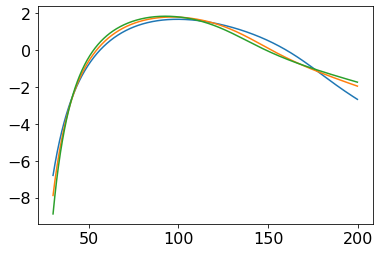

In [5]:
plt.figure()
for s in seed_ts:
    plt.plot(seed_x, s)

In [6]:
# Make integration rule

int_range = [seed_x[0], seed_x[-1]]
int_num = len(seed_x)

integration = greedyrb.Riemann(int_range, num=int_num)
x = integration.nodes  # Define x for convenience

In [7]:
# create GreedyReducedBasis instance

grb = greedyrb.GreedyReducedBasis(
    integration=integration
)

In [8]:
grb.build_seed_basis(ts=seed_ts, ts_coords=seed_ts_coords)

In [9]:
grb.basis.shape

(3, 1360)

In [10]:
grb.greedy_points

array([[ 1. ],
       [ 5.5],
       [10. ]])

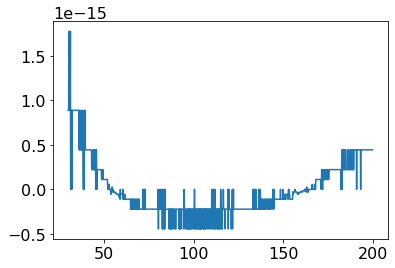

In [11]:
plt.figure()
plt.plot(x, grb.compute_representation_ts(seed_ts[0]) - seed_ts[0])

In [12]:
# now lets perform a greedy sweep

In [13]:
sweep_q_array = np.random.uniform(1, 10, 100)
_, ts, ts_coords = gen_1d_massratio_data(sweep_q_array, 100)

In [14]:
# _, ts, ts_coords = gen_1d_massratio_data([19], 100)

In [15]:
grb.greedy_sweep(ts, ts_coords, greedy_tol=1e-9)
# grb.greedy_sweep(ts, ts_coords, greedy_tol=1e-4)
# grb.greedy_sweep(ts, ts_coords, greedy_tol=1e-12)

step = 0, error = 0.09996376925088618
step = 1, error = 0.0015014049385362557
step = 2, error = 0.00019096971827316144
step = 3, error = 2.7568298636045717e-05
step = 4, error = 4.549222772174132e-07
step = 5, error = 3.6408158134889674e-08
step = 6, error = 4.1514479495991184e-09
step = 7, error = 2.6579383932710287e-09
step = 8, error = 1.0925550607533538e-09
tolerance reached. exiting


In [16]:
grb.greedy_points

array([[ 1.        ],
       [ 5.5       ],
       [10.        ],
       [ 2.45465213],
       [ 3.62963462],
       [ 1.7592295 ],
       [ 8.05053795],
       [ 1.3597673 ],
       [ 4.39077649],
       [ 6.67218156],
       [ 2.92632556],
       [ 9.25691287]])

Text(0.5, 0, '$q$')

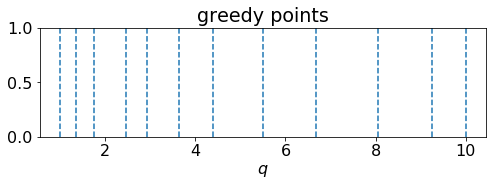

In [17]:
plt.figure(figsize=(8, 2))
for gp in grb.greedy_points:
    plt.axvline(gp, ls='--')
plt.title("greedy points")
plt.xlabel(r'$q$')

Text(0.5, 0, 'iteration')

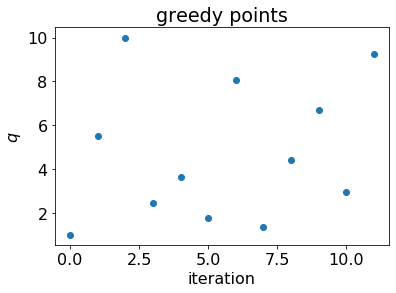

In [18]:
plt.scatter(range(grb.nbasis), grb.greedy_points)
plt.title("greedy points")
plt.ylabel(r'$q$')
plt.xlabel('iteration')

In [19]:
# validate the current basis

validation_q_array = np.random.uniform(1, 10, 1000)
_, validation_ts, validation_ts_coords = gen_1d_massratio_data(validation_q_array, 100)

errors = grb.compute_greedy_error(validation_ts)

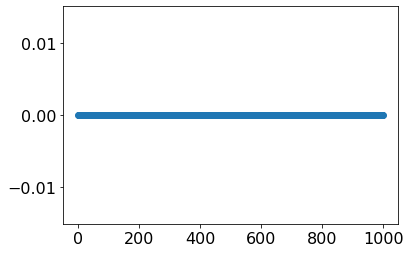

In [20]:
plt.figure()
plt.scatter(range(len(errors)), errors)

now we seem to have a basis that spans the parameter space
we care about we move on to the next step:

constructing an empirical interpolant for temporal compression.

# empirical interpolant: eim

eim training data is the data to fit
generated at the greedy points

we also need the reduced basis

In [21]:
_, eim_ts, eim_ts_coords = gen_1d_massratio_data(grb.greedy_points.ravel(), 100)

In [22]:
grb.build_eim(eim_ts)

In [23]:
grb.eim.B

array([[ 1.00000000e+00,  9.68929828e-01,  9.38664049e-01, ...,
         4.91735402e-04,  2.47890161e-04, -2.42924088e-17],
       [ 0.00000000e+00, -4.77348857e-03, -9.30977439e-03, ...,
         9.74079864e-01,  9.87032278e-01,  1.00000000e+00],
       [ 0.00000000e+00,  4.55026246e-02,  8.95040774e-02, ...,
         2.81580378e-03,  1.41564217e-03, -8.19903759e-17],
       ...,
       [ 0.00000000e+00, -7.85405366e-03, -1.52984095e-02, ...,
         1.18980462e-03,  5.98913137e-04, -1.85931603e-17],
       [ 0.00000000e+00, -8.05639606e-03, -1.56929993e-02, ...,
         3.24820323e-03,  1.63468638e-03, -1.77700492e-18],
       [ 0.00000000e+00, -4.64906323e-03, -9.05500385e-03, ...,
         4.13163340e-04,  2.08137279e-04, -5.32747381e-18]])

In [24]:
grb.eim.data.shape

(12, 12)

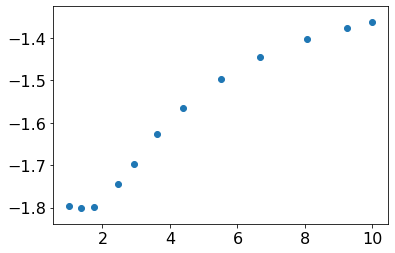

In [25]:
plt.figure()
plt.scatter(grb.greedy_points.ravel(), grb.eim.data[5])

# fit eim data

In [26]:
# from sklearn.linear_model import Ridge, LinearRegression, Lasso, ElasticNet, Lars, LassoLars, BayesianRidge, Perceptron
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.pipeline import make_pipeline
# from sklearn.model_selection import GridSearchCV

# from scipy.stats import uniform
# from sklearn.model_selection import RandomizedSearchCV

# class Fit(object):
#     def __init__(self, domain, values):
#         """
#         input:
#             domain: numpy.ndarray
#                 N,M matrix where N is the number of entries
#                 and M is the number of coordinates
#             values: numpy.ndarray
#                 N matrix
#         """
#         self.domain = domain
#         self.values = values
#         self.npoints = len(values)
        
#     def fit(self, method, degree=4, cv=5):
        
#         if method == "bayesian":
#             self.grid = self._PolynomialRegression_Bayesian(degree=degree)
#         elif method == "linear":
#             self.grid = self._PolynomialRegression_LinearRegression(degree=degree)
#         elif method == "linear_grid":
#             self.grid = self._PolynomialRegression_LinearRegression_Grid(max_degree=degree, cv=cv)
        
#         # for 1d data
#         self.grid.fit(self.domain.reshape(-1,1), self.values.reshape(-1,1).ravel())
        
#         if method == "bayesian":
#             self.model = self.grid.best_estimator_
#         elif method == "linear":
#             self.model = self.grid
#         elif method == "linear_grid":
#             self.model = self.grid.best_estimator_
        
        
        
        
#     def eval(self, domain):
#         return self.model.predict(domain)
        
        
#     def _PolynomialRegression_Bayesian(self, degree=6, **kwargs):
        
#         pipeline = make_pipeline(PolynomialFeatures(degree),
#                                  BayesianRidge(**kwargs))

#         spacing = 1./np.logspace(-5,10,20)

#         param_grid = {'polynomialfeatures__degree': np.arange(20),
#                       'bayesianridge__fit_intercept': [True, False],
#                       'bayesianridge__normalize': [True, False],
#                       'bayesianridge__alpha_1': spacing,
#                       'bayesianridge__alpha_2': spacing,
#                       'bayesianridge__lambda_1': spacing,
#                       'bayesianridge__lambda_2': spacing
#                      }

#         grid = RandomizedSearchCV(
#             pipeline,
#             param_grid,
#             random_state=1,
#             n_iter=20,
#             cv=4,
#             verbose=0,
#             n_jobs=-1)
        
#         return grid

#     def _PolynomialRegression_LinearRegression(self, degree=6, **kwargs):
        
#         pipeline = make_pipeline(PolynomialFeatures(degree),
#                                  LinearRegression(**kwargs))

#         return pipeline

    
    
#     def _PolynomialRegression_LinearRegression_Grid(self, max_degree, cv, **kwargs):

#         def _PolynomialRegression(degree=2, **kwargs):
#             return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

#         param_grid = {
#             'polynomialfeatures__degree': np.arange(max_degree),
#             'linearregression__fit_intercept': [True, False],
#             'linearregression__normalize': [True, False]}


#         grid = GridSearchCV(_PolynomialRegression(), param_grid, 
#                                  cv=cv, 
#                                  scoring='neg_mean_squared_error', 
#                                  verbose=0) 

#         return grid

In [27]:
grb.nbasis

12

dimensionality of space = 1


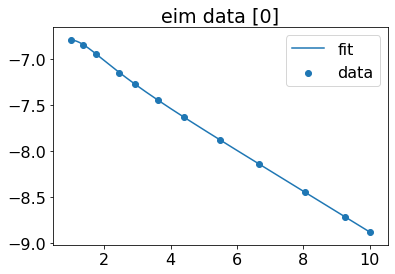

dimensionality of space = 1


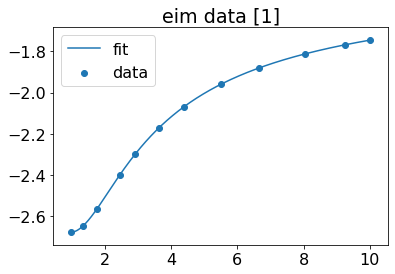

dimensionality of space = 1


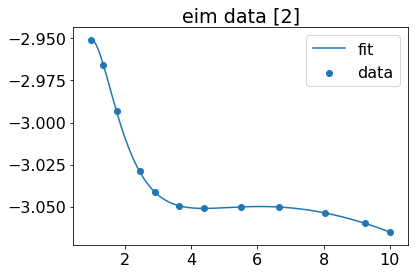

dimensionality of space = 1


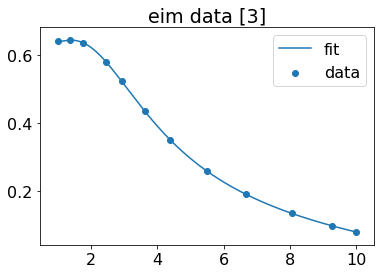

dimensionality of space = 1


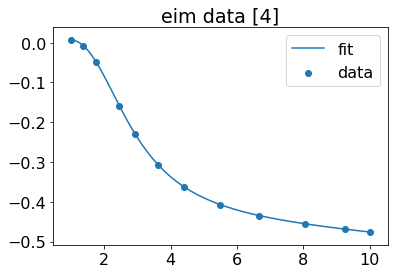

dimensionality of space = 1


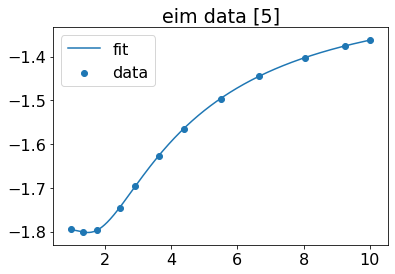

dimensionality of space = 1


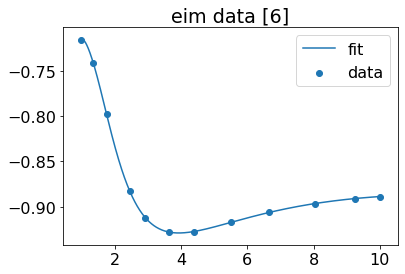

dimensionality of space = 1


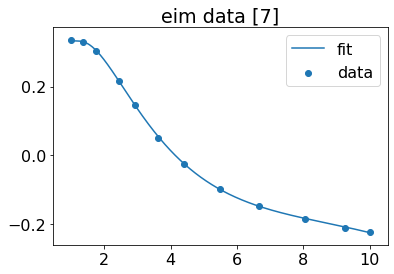

dimensionality of space = 1


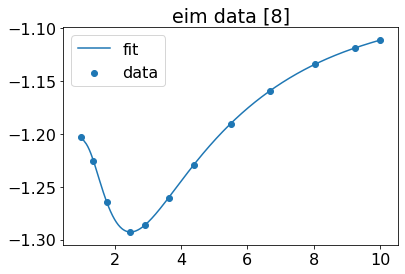

dimensionality of space = 1


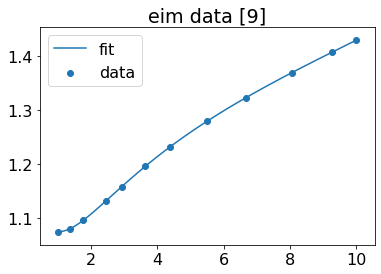

dimensionality of space = 1


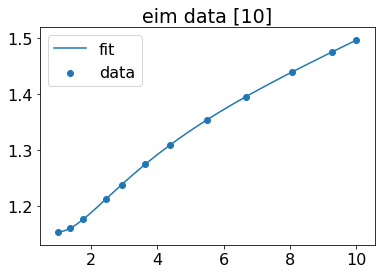

dimensionality of space = 1


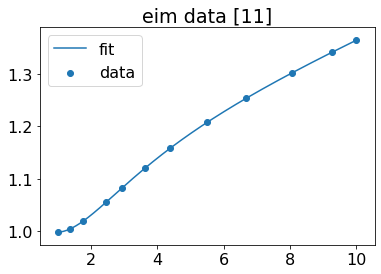

In [28]:
verbose=True
fits = []

fit_transform_log_q = True

if fit_transform_log_q:
    x_to_fit = np.log(grb.greedy_points)
else:
    x_to_fit = grb.greedy_points
    
for i, eim_y in enumerate(grb.eim.data):
    fit = Fit(domain=x_to_fit, values=eim_y)
    fit.fit(method='linear_grid', degree=grb.nbasis)
#     fit.fit(method='linear', degree=8)
    fits.append(fit)
    
    if verbose:
        
        xhat = np.linspace(grb.greedy_points.min(), grb.greedy_points.max(), 1000)
        if fit_transform_log_q:
            xhat = np.log(xhat)
        yhat = fit.eval(xhat.reshape(-1,1))
        
        plt.figure()
        plt.title(f"eim data [{i}]")
        if fit_transform_log_q:
            plt.plot(np.exp(xhat), yhat, label='fit')
            plt.scatter(np.exp(x_to_fit.ravel()), eim_y, label='data')
        else:
            plt.plot(xhat, yhat, label='fit')
            plt.scatter(x_to_fit.ravel(), eim_y, label='data')
        plt.legend()
        plt.show()
        plt.close()

# final surrogate model

In [29]:
def surrogate(q, fits, basis):
    
    if fit_transform_log_q:
        q = np.log(q)
    
    alpha = np.zeros(len(fits))
    for i in range(len(fits)):
        alpha[i] = fits[i].eval([[q]])

    return np.dot(alpha, basis)

In [30]:
sur = surrogate(6, fits, grb.eim.B)

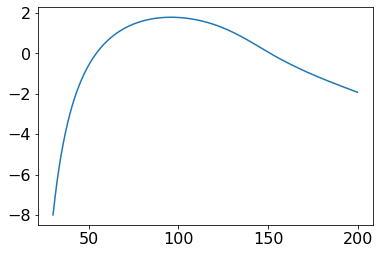

In [31]:
plt.figure()
plt.plot(x, sur)

In [32]:
# validate the current basis

model_validation_q_array = np.random.uniform(1, 10, 1000)
_, model_validation_ts, model_validation_ts_coords = gen_1d_massratio_data(model_validation_q_array, 100)


model_errors = []
for i in range(len(model_validation_q_array)):
    q = model_validation_q_array[i]
    sur = surrogate(q, fits, grb.eim.B)
    vts = model_validation_ts[i]
    error = grb.integration.norm(vts - sur)**2
    model_errors.append(error)
model_errors = np.array(model_errors)
    
max_idx = np.argmax(model_errors)
print(max_idx)
print(model_validation_q_array[max_idx])
worst_q = model_validation_q_array[max_idx]

713
1.0860154784377003


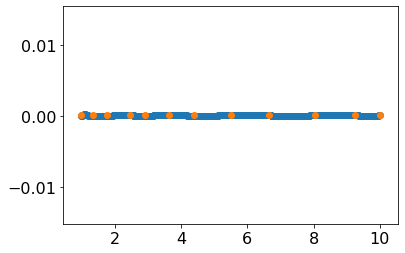

In [33]:
plt.figure()
plt.scatter(model_validation_q_array, model_errors)
plt.scatter(grb.greedy_points, np.ones(grb.nbasis)*np.mean(model_errors))

In [34]:
def plot_model_and_data_at_point(q):

    _, ts, _ = gen_1d_massratio_data(np.array([q]), 100)
    ts = ts[0]

    sur = surrogate(q, fits, grb.eim.B)

    error = grb.integration.norm(ts - sur)**2
    print(error)
    
    plt.figure()
    plt.plot(x, ts)
    plt.plot(x, sur)
    plt.show()
    plt.close()

0.00022746563775698458


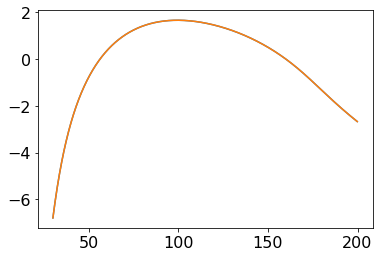

In [35]:
plot_model_and_data_at_point(worst_q)

5.39979598784276e-05


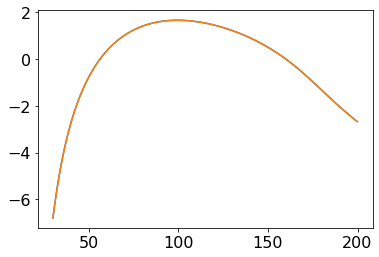

In [36]:
plot_model_and_data_at_point(1.02)

1.2692929780601662e-06


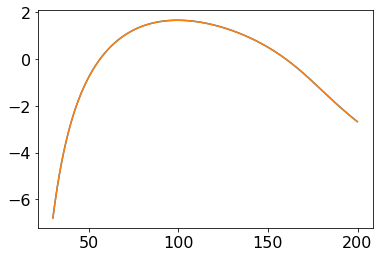

In [37]:
plot_model_and_data_at_point(1)

2.5621520008628182e-05


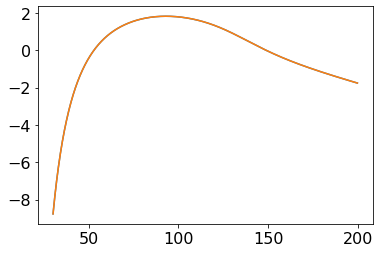

In [38]:
plot_model_and_data_at_point(9.5)